In [1]:
#!pip install tensorflow_text

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [3]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.Category.value_counts() #IMBALANCED

ham     4825
spam     747
Name: Category, dtype: int64

# We will use Down-Sampling but what is Down-Sampling?

Down-sampling, in the context of data analysis and signal processing, refers to the process of reducing the number of samples or data points in a dataset or signal. It involves taking a subset of the original data by aggregating or averaging neighboring points, which effectively decreases the resolution of the data.


We use down-sampling for various reasons:

* Computational Efficiency: In large datasets or high-frequency signals, there can be a massive number of data points, making processing time-consuming and resource-intensive.
* Down-sampling helps reduce the data size, making computations faster and more manageable.
* Noise Reduction: Sometimes, data contains noise or random fluctuations that might not be relevant to the analysis. Down-sampling can help smooth out the noise by averaging nearby points, improving signal-to-noise ratio and making underlying patterns more apparent.
* Visualization: For visual representation of data, particularly in plots and charts, down-sampling can be useful to prevent overcrowding of data points and enhance the clarity of the visualizations.
* Preventing Overfitting: In machine learning and statistical modeling, down-sampling can be employed to balance imbalanced datasets, avoiding overfitting by reducing the influence of dominant classes or outliers.





In [5]:
df_spam = df[df["Category"] == 'spam']
df_spam.shape

(747, 2)

In [6]:
df_ham = df[df["Category"] == "ham"]
df_ham.shape

(4825, 2)

In [7]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])

In [8]:
df_ham_downsampled.shape

(747, 2)

In [9]:
df_balanced = pd.concat([df_spam, df_ham_downsampled])
df_balanced["Category"].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [10]:
df_balanced["spam"] = df_balanced["Category"].apply(lambda x: 1 if x == 'spam' else 0)
df_balanced.head(5)

,Category,Message,spam
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train ,y_test = train_test_split(df_balanced["Message"], df_balanced["spam"], stratify=df_balanced["spam"])

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1120,), (374,), (1120,), (374,))

In [13]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [14]:
def get_sentence_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)["pooled_output"]

## What is actually pooled_output?

*Pooled output is the embedding of the [CLS] token (from Sequence output), further processed by a Linear layer and a Tanh activation function.

In [15]:
# Then let's explore how Bert actually works with the help of Cosine Similarity

tokens = get_sentence_embedding([
    "wife",
    "husband",
    "baby",
    "little",
    "big",
    "coffee"
])


In [16]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([tokens[0]], [tokens[1]])
# It gave us %90 similarity between "wife" and "husband" It's pretty cool!

array([[0.9799452]], dtype=float32)

In [17]:
# Bert Layers
from keras.layers import Input
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = "text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [18]:
# Neural Network Layers
l = tf.keras.layers.Dropout(0.1, name="Dropout")(outputs["pooled_output"])
l = tf.keras.layers.Dense(1, activation = "sigmoid", name = "output")(l)

#Construct final model
model = tf.keras.Model(inputs= [text_input], outputs = [l])

In [19]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(lr = 0.01),
    metrics = ["accuracy"]
)

model.fit(X_train, y_train, epochs =10)

Epoch 1/10
35/35 [==============================] - 21s 331ms/step - loss: 0.6750 - accuracy: 0.5545
Epoch 2/10
35/35 [==============================] - 12s 333ms/step - loss: 0.5384 - accuracy: 0.7884
Epoch 3/10
35/35 [==============================] - 11s 329ms/step - loss: 0.4611 - accuracy: 0.8402
Epoch 4/10
35/35 [==============================] - 11s 321ms/step - loss: 0.4116 - accuracy: 0.8562
Epoch 5/10
35/35 [==============================] - 12s 339ms/step - loss: 0.3764 - accuracy: 0.8714
Epoch 6/10
35/35 [==============================] - 12s 341ms/step - loss: 0.3574 - accuracy: 0.8821
Epoch 7/10
35/35 [==============================] - 12s 341ms/step - loss: 0.3347 - accuracy: 0.8911
Epoch 8/10
35/35 [==============================] - 12s 349ms/step - loss: 0.3182 - accuracy: 0.8946
Epoch 9/10
35/35 [==============================] - 12s 341ms/step - loss: 0.3003 - accuracy: 0.8973
Epoch 10/10
35/35 [==============================] - 12s 341ms/step - loss: 0.2905 - accura

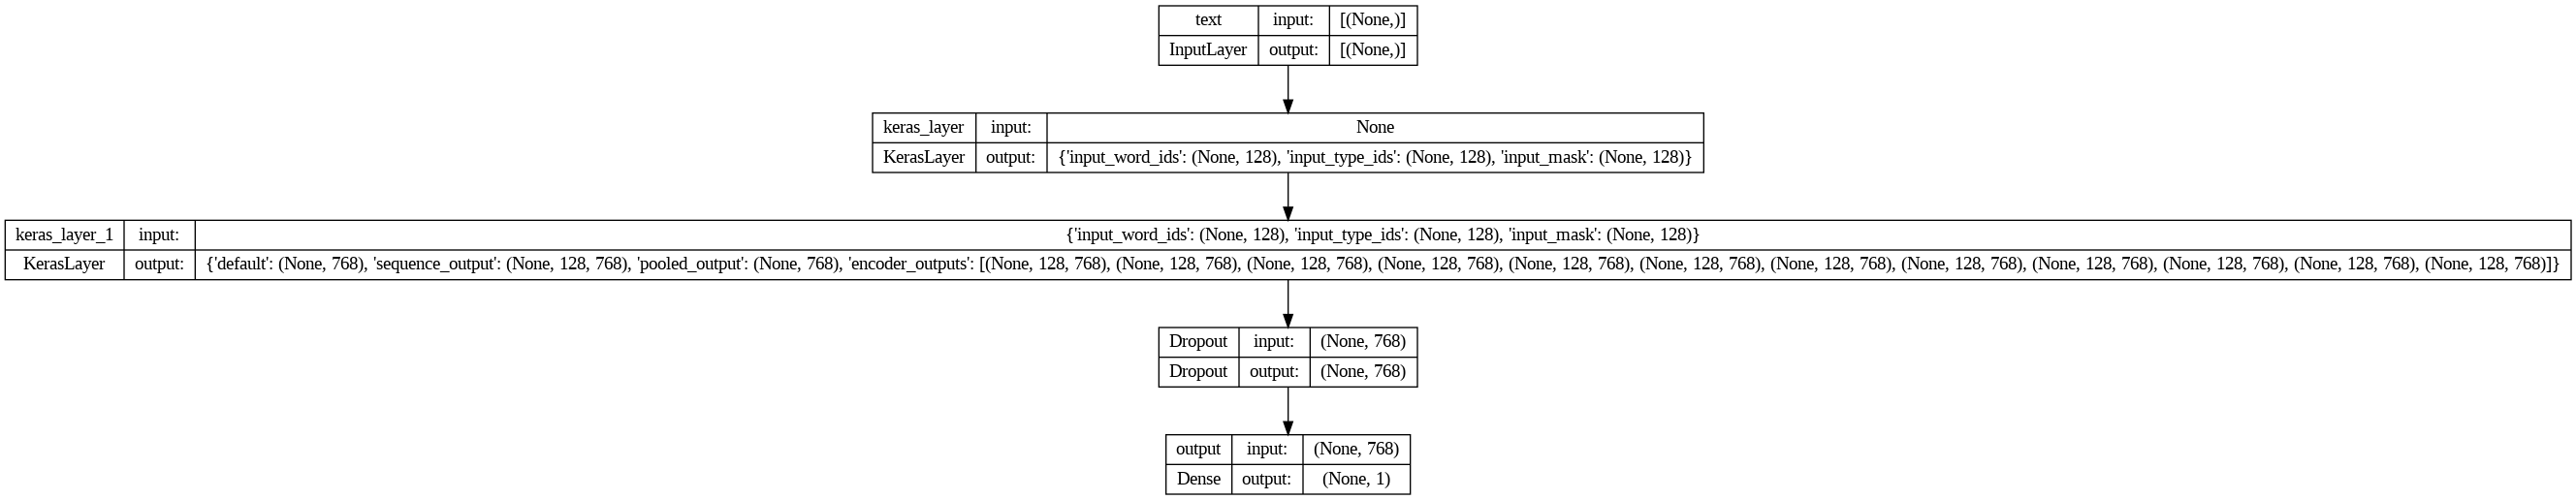

In [20]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True,)

In [21]:
print("LOSS: ",model.evaluate(X_test,y_test)[0])
print("ACC: ", model.evaluate(X_test,y_test)[0])


12/12 [==============================] - 5s 357ms/step - loss: 0.2795 - accuracy: 0.9064
LOSS:  0.2794816195964813
12/12 [==============================] - 4s 310ms/step - loss: 0.2795 - accuracy: 0.9064
ACC:  0.2794816195964813
